# EQUITY AMERICAN OPTION - BAW APPROXIMATION

Valuation and Risk of American-style options on equity using BAW approximation

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [1]:
from financepy.finutils import *
from financepy.market.curves.TuringDiscountCurveFlat import *
from financepy.products.equity import *
from financepy.models.FinModelBlackScholes import *

ModuleNotFoundError: No module named 'financepy.market.curves.TuringDiscountCurveFlat'

# Define the Call and Put Options

In [3]:
valueDate = TuringDate(8, 5, 2015)

In [4]:
expiryDate = TuringDate(15, 1, 2016)

In [5]:
strikePrice = 130

Create the call Option

In [6]:
amCallOption = TuringEquityAmericanOption(expiryDate, strikePrice, TuringOptionTypes.AMERICAN_CALL)

In [7]:
print(amCallOption)

OBJECT TYPE: TuringEquityAmericanOption
EXPIRY DATE: 15-JAN-2016
STRIKE PRICE: 130
OPTION TYPE: TuringOptionTypes.AMERICAN_CALL
NUMBER: 1.0


We can also define an American option with a European payoff - this way we will use the same CRR tree for the pricing.

In [8]:
euCallOption = TuringEquityAmericanOption(expiryDate, strikePrice, TuringOptionTypes.EUROPEAN_CALL)

We can also define an actual vanilla call option which will be priced using Black Scholes.

In [9]:
callOption = FinEquityVanillaOption(expiryDate, strikePrice, TuringOptionTypes.EUROPEAN_CALL)

Now we can explore the pricing of all three to check for consistency and tree convergence.

## Valuation

In [16]:
stockPrice = 127.62
volatility = 0.20
interestRate = 0.001
dividendYield = 0.0163

In [17]:
discountCurve = TuringDiscountCurveFlat(valueDate, interestRate,
                                     TuringFrequencyTypes.CONTINUOUS, 
                                     TuringDayCountTypes.ACT_365F)

In [18]:
dividendCurve = TuringDiscountCurveFlat(valueDate, dividendYield)

We now define the model. This is Black-Scholes. We can also specify the number of steps to use on the tree,

In [19]:
numStepsPerYear = 400

In [20]:
modelTree = FinModelBlackScholes(volatility, 
                                 FinModelBlackScholesTypes.CRR_TREE, 
                                 {'numStepsPerYear':numStepsPerYear} )

In [21]:
amCallOption.value(valueDate, stockPrice, discountCurve, dividendCurve, modelTree)

6.8391380697921615

In [22]:
modelApprox = FinModelBlackScholes(volatility, FinModelBlackScholesTypes.BARONE_ADESI)

In [23]:
amCallOption.value(valueDate, stockPrice, discountCurve, dividendCurve, modelApprox)

6.827753597158052

Compare it to European using same tree

In [24]:
euCallOption.value(valueDate, stockPrice, discountCurve, dividendCurve, modelTree)

6.751136062156512

This is lower as we would expect due to the lack of early exercise. Let's check this against the Black Scholes model analytical form.

In [25]:
modelAnal = FinModelBlackScholes(volatility, FinModelBlackScholesTypes.ANALYTICAL)

In [26]:
callOption.value(valueDate, stockPrice, discountCurve, dividendCurve, modelAnal)

6.749356623876585

The price is close to the 6.74927 found by QL - see http://gouthamanbalaraman.com/blog/european-option-binomial-tree-quantlib-python.html. Differences with QL could be due to differences in time calculations. It is also different from the Tree value but that is a tree convergence issue. Let's see how good convergence is.

## Tree Convergence

In [27]:
numStepsPerYear = range(5, 200, 1)

In [28]:
amTreeValue = []
amBAWValue = []
euTreeValue = []
euAnalValue = []

volatility = 0.20

for numSteps in numStepsPerYear:

    modelTree = FinModelBlackScholes(volatility,
                                     FinModelBlackScholesTypes.CRR_TREE,
                                     {'numStepsPerYear':numSteps})

    modelAnal = FinModelBlackScholes(volatility, 
                                     FinModelBlackScholesTypes.ANALYTICAL)

    modelBAW = FinModelBlackScholes(volatility, 
                                    FinModelBlackScholesTypes.BARONE_ADESI)

    v_am = amCallOption.value(valueDate, stockPrice, discountCurve, dividendCurve, modelTree)
    v_eu = euCallOption.value(valueDate, stockPrice, discountCurve, dividendCurve, modelTree)
    v_bs = callOption.value(valueDate, stockPrice, discountCurve, dividendCurve, modelAnal)
    v_am_baw = amCallOption.value(valueDate, stockPrice, discountCurve, dividendCurve, modelBAW)

    amTreeValue.append(v_am)
    euTreeValue.append(v_eu)
    euAnalValue.append(v_bs)
    amBAWValue.append(v_am_baw)


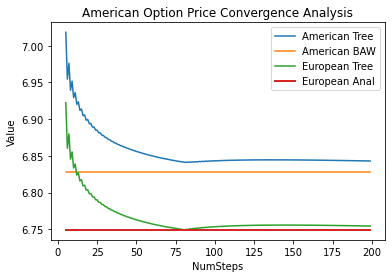

In [37]:
plt.title("American Option Price Convergence Analysis")
plt.plot(numStepsPerYear, amTreeValue, label="American Tree")
plt.plot(numStepsPerYear, amBAWValue, label="American BAW")
plt.plot(numStepsPerYear, euTreeValue, label="European Tree")
plt.plot(numStepsPerYear, euAnalValue, label="European Anal", lw =2)
plt.xlabel("NumSteps")
plt.ylabel("Value")
plt.legend();

Agreement with QL is very good and tree convergence appears much better - probably assisted by fact that I average even and odd numbers of steps internally.

Copyright (c) 2020 Dominic O'Kane